In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from kernels import *
import pdb
import gpytorch
from itertools import product

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
train_x = torch.linspace(float(-2), float(2), int(50))
# The original sin/cos data
#one = torch.sin(train_x * (float(2) * math.pi)) + torch.randn(train_x.size()) * float(0.2)
#two = torch.cos(train_x * (float(2) * math.pi)) + torch.randn(train_x.size()) * float(0.02)

# Polynomials + diff(poly) data
#one = torch.pow(train_x, int(3)) + torch.randn(train_x.size()) * float(0.2)
#two = int(3)*torch.pow(train_x, int(2)) + torch.randn(train_x.size()) * float(0.2)

# Polynomials + diff(poly) data
one = torch.pow(train_x, int(3)) + torch.randn(train_x.size()) * float(0.2)
two = int(3)*train_x**int(2) + torch.randn(train_x.size()) * float(0.2)

# Combined poly + sin/cos
#one = torch.mul(torch.sin(train_x), train_x)+ torch.randn(train_x.size()) * float(0.2)
#two = torch.mul(torch.cos(train_x), train_x) + torch.sin(train_x) + torch.randn(train_x.size()) * float(0.2)

# only sin/cos
#one = torch.mul(torch.sin(train_x), torch.cos(train_x)) + torch.randn(train_x.size()) * float(0.2)
#two = torch.mul(torch.cos(train_x), torch.cos(train_x)) - torch.mul(torch.sin(train_x), torch.sin(train_x)) + torch.randn(train_x.size()) * float(0.2)

train_y = torch.stack([one,two], int(-1))
#train_y = torch.stack([one, two], int(-1))


In [3]:
print(train_x)
print(train_y)
print(np.shape(train_y))

# = torch.Tensor([[float(-0.3), float(0.99)],[float(-0.07), float(1.01)]])

tensor([-2.0000, -1.9184, -1.8367, -1.7551, -1.6735, -1.5918, -1.5102, -1.4286,
        -1.3469, -1.2653, -1.1837, -1.1020, -1.0204, -0.9388, -0.8571, -0.7755,
        -0.6939, -0.6122, -0.5306, -0.4490, -0.3673, -0.2857, -0.2041, -0.1224,
        -0.0408,  0.0408,  0.1224,  0.2041,  0.2857,  0.3673,  0.4490,  0.5306,
         0.6122,  0.6939,  0.7755,  0.8571,  0.9388,  1.0204,  1.1020,  1.1837,
         1.2653,  1.3469,  1.4286,  1.5102,  1.5918,  1.6735,  1.7551,  1.8367,
         1.9184,  2.0000])
tensor([[-8.0697e+00,  1.2073e+01],
        [-7.3801e+00,  1.1009e+01],
        [-6.2918e+00,  1.0199e+01],
        [-5.2987e+00,  9.2867e+00],
        [-4.5310e+00,  8.4812e+00],
        [-3.8128e+00,  7.6785e+00],
        [-3.6327e+00,  7.1720e+00],
        [-2.8841e+00,  6.2695e+00],
        [-1.7612e+00,  5.2651e+00],
        [-2.1909e+00,  4.6455e+00],
        [-2.0198e+00,  4.3739e+00],
        [-1.6828e+00,  3.6600e+00],
        [-9.9007e-01,  3.2186e+00],
        [-7.6762e-01,  2.

In [4]:

len(train_y.shape)

2

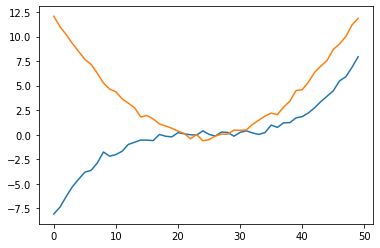

In [5]:
plt.plot(train_y)

$$
\begin{align}
L =& 
\left[
\begin{matrix}
1 & dx_1 \\
0 & 1
\end{matrix}
\right]\\
R =& 
\left[
\begin{matrix}
1 & 0\\
dx_2 & 1
\end{matrix}
\right]\\
\hat{k} =& 
\left[
\begin{matrix}
SE_1 & 0\\
0 & SE_2
\end{matrix}
\right]\\
k =& L*\hat{k}*R\\
=& \left[
\begin{matrix}
dx_1 dx_2 SE_2 + SE_1 & dx_1 SE_2\\
dx_2 SE_2 & SE_2
\end{matrix}
\right]
\end{align}
$$

In [6]:
dx1, dx2, k1, k2, f, g = var('dx1, dx2, k1, k2, f, g')
K = matrix(2,2, (k1, 0, 0, 0))
L = matrix(2, 2, (1, 0, dx1^2, 1))
R = matrix(2, 2, (1, dx2^2, 0, 1))
L*K*R
# used to see how the data should be created if I 
# decide to create it exactly as I create the kernel
#K = matrix(2,1, (f, g))
#L*L*K

[            k1       dx2^2*k1]
[      dx1^2*k1 dx1^2*dx2^2*k1]

In [7]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=2
        )
        kernel = Diff_SE_kernel(var=0, length=0)
        kernel2 = Diff_SE_kernel(var=0, length=0)
        q, dx1, dx2 = var('q, dx1, dx2')
        L = matrix(2, 2, (1, 0, dx1, 1))
        R = matrix(2, 2, (1, dx2, 0, 1))
        p = DiffMatrixKernel([[kernel, None], [None, None]])
        self.covar_module = p.diff(left_matrix=L, right_matrix=R)
        
        #kernel0 = gpytorch.kernels.RBFKernel()
        #kernel1 = gpytorch.kernels.RBFKernel()
        #kernel2 = gpytorch.kernels.RBFKernel()
        #kernel0 = gpytorch.kernels.PeriodicKernel()
        #kernel1 = gpytorch.kernels.PeriodicKernel()
        #kernel0 = Diff_SE_kernel(var = 0, length=0)
        #kernel1 = Diff_SE_kernel(var = 0, length=0.01)
        #kernel2 = Diff_SE_kernel(var = 0, length=0.02)
        #self.covar_module = MatrixKernel([[kernel0, kernel2], [None, kernel1]])

    def forward(self, x):
        #pdb.set_trace()
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        #print(f"{covar_x.detach().evaluate()}")
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x, validate_args=True)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
#likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2, has_global_noise=False, has_task_noise=False)
likelihood._set_task_noises(torch.Tensor([float(0.0001),float(0.0001)]))
#likelihood._set_noise(torch.tensor(float(0.0001)))
model = MultitaskGPModel(train_x, train_y, likelihood)

List of all kernels: [Diff_SE_kernel()]
[[diffed_SE_kernel(), diffed_SE_kernel()], [diffed_SE_kernel(), diffed_SE_kernel()]]


In [8]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = int(2) if smoke_test else int(75)


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=float(0.1))  # Includes GaussianLikelihood parameters


# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

param_dict = {p[0]:[] for p in model.named_parameters() if 'covar' in p[0]}
param_dict['loss'] = []
param_dict['noise'] = []
if len(likelihood.task_noises) > 1:
    param_dict['task_noises'] = [[] for i in range(len(likelihood.task_noises))]
for p in model.named_parameters():
    if 'covar' in p[0]:
        param_dict[f"{p[0]}_grad"] = []

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    param_dict['loss'].append(loss.item())
    #pdb.set_trace()
    loss.backward()
    for parameter in model.named_parameters():
        if 'covar' in parameter[0]:
            param_dict[parameter[0]].append(parameter[1].item())
            #param_dict[f"{parameter[0]}_grad"].append(parameter[1].grad.item())
    param_dict['noise'].append(likelihood.noise.item())
    for l in range(len(likelihood.task_noises)):
        param_dict['task_noises'][l].append(likelihood.task_noises[l].item())
    #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f  variance: %.3f noise: %.3f' % (
    #    i + 1, training_iter, loss.item(),
    #    model.covar_module.length.item(),
    #    model.covar_module.var.item(),
    #    model.likelihood.noise.item()
    #))
    optimizer.step()

tensor([[ 1.0000e+00,  0.0000e+00,  9.9667e-01,  ..., -1.8160e-03,
          3.3546e-04, -1.3419e-03],
        [ 0.0000e+00,  1.0000e+00,  8.1361e-02,  ..., -6.6522e-03,
          1.3419e-03, -5.0319e-03],
        [ 9.9667e-01,  8.1361e-02,  1.0000e+00,  ..., -2.4403e-03,
          4.6345e-04, -1.8160e-03],
        ...,
        [-1.8160e-03, -6.6522e-03, -2.4403e-03,  ...,  1.0000e+00,
          8.1361e-02,  9.9003e-01],
        [ 3.3546e-04,  1.3419e-03,  4.6345e-04,  ...,  8.1361e-02,
          1.0000e+00,  0.0000e+00],
        [-1.3419e-03, -5.0319e-03, -1.8160e-03,  ...,  9.9003e-01,
          0.0000e+00,  1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.2969e+01,  0.0000e+00],
        [ 2.8123e+01,  0.0000e+00],
        [ 1.8031e+01,  0.0000e+00],
        [ 1.1853e+01,  0.0000e+00],
        [ 6.0685e+00,  0.0000e+00],
        [ 2.2329e+00,  0.0000e+00],
        [ 5.8205e-01,  0.0000e+00],
        [ 1.1878e-01,  0.0000e+00],
        [ 2.0032e-02,

/Users/andreas/Documents/container_storage/sage/DiffEqGPs/kernels.py:669: UserWarning: torch.eig is deprecated in favor of torch.linalg.eig and will be removed in a future PyTorch release.
torch.linalg.eig returns complex tensors of dtype cfloat or cdouble rather than real tensors mimicking complex tensors.
L, _ = torch.eig(A)
should be replaced with
L_complex = torch.linalg.eigvals(A)
and
L, V = torch.eig(A, eigenvectors=True)
should be replaced with
L_complex, V_complex = torch.linalg.eig(A) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2897.)
  print(result.eig())


tensor([[ 1.1052e+00,  0.0000e+00,  1.1007e+00,  ..., -4.4797e-04,
          6.3073e-05, -3.0815e-04],
        [ 0.0000e+00,  1.3499e+00,  1.0974e-01,  ..., -2.0296e-03,
          3.0815e-04, -1.4285e-03],
        [ 1.1007e+00,  1.0974e-01,  1.1052e+00,  ..., -6.4567e-04,
          9.3601e-05, -4.4797e-04],
        ...,
        [-4.4797e-04, -2.0296e-03, -6.4567e-04,  ...,  1.3499e+00,
          1.0974e-01,  1.3334e+00],
        [ 6.3073e-05,  3.0815e-04,  9.3601e-05,  ...,  1.0974e-01,
          1.1052e+00,  0.0000e+00],
        [-3.0815e-04, -1.4285e-03, -4.4797e-04,  ...,  1.3334e+00,
          0.0000e+00,  1.3499e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.6211e+01,  0.0000e+00],
        [ 3.3365e+01,  0.0000e+00],
        [ 2.2125e+01,  0.0000e+00],
        [ 1.5734e+01,  0.0000e+00],
        [ 9.2781e+00,  0.0000e+00],
        [ 4.2461e+00,  0.0000e+00],
        [ 1.3647e+00,  0.0000e+00],
        [ 3.4174e-01,  0.0000e+00],
        [ 7.0430e-02,

tensor([[ 1.3472e+00,  0.0000e+00,  1.3391e+00,  ..., -9.3052e-06,
          7.3574e-07, -5.3048e-06],
        [ 0.0000e+00,  2.4283e+00,  1.9704e-01,  ..., -6.3348e-05,
          5.3048e-06, -3.6922e-05],
        [ 1.3391e+00,  1.9704e-01,  1.3472e+00,  ..., -1.6120e-05,
          1.3174e-06, -9.3052e-06],
        ...,
        [-9.3052e-06, -6.3348e-05, -1.6120e-05,  ...,  2.4283e+00,
          1.9704e-01,  2.3848e+00],
        [ 7.3574e-07,  5.3048e-06,  1.3174e-06,  ...,  1.9704e-01,
          1.3472e+00,  0.0000e+00],
        [-5.3048e-06, -3.6922e-05, -9.3052e-06,  ...,  2.3848e+00,
          0.0000e+00,  2.4283e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 4.5638e+01,  0.0000e+00],
        [ 4.6948e+01,  0.0000e+00],
        [ 3.2998e+01,  0.0000e+00],
        [ 2.5681e+01,  0.0000e+00],
        [ 1.7101e+01,  0.0000e+00],
        [ 1.1770e+01,  0.0000e+00],
        [ 5.6757e+00,  0.0000e+00],
        [ 2.1132e+00,  0.0000e+00],
        [ 6.3810e-01,

tensor([[ 1.6338e+00,  0.0000e+00,  1.6197e+00,  ..., -3.6851e-08,
          1.5658e-09, -1.6258e-08],
        [ 0.0000e+00,  4.2409e+00,  3.4322e-01,  ..., -3.6541e-07,
          1.6258e-08, -1.6474e-07],
        [ 1.6197e+00,  3.4322e-01,  1.6338e+00,  ..., -8.2062e-08,
          3.6232e-09, -3.6851e-08],
        ...,
        [-3.6851e-08, -3.6541e-07, -8.2062e-08,  ...,  4.2409e+00,
          3.4322e-01,  4.1317e+00],
        [ 1.5658e-09,  1.6258e-08,  3.6232e-09,  ...,  3.4322e-01,
          1.6338e+00,  0.0000e+00],
        [-1.6258e-08, -1.6474e-07, -3.6851e-08,  ...,  4.1317e+00,
          0.0000e+00,  4.2409e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 6.4626e+01,  0.0000e+00],
        [ 6.2694e+01,  0.0000e+00],
        [ 4.6384e+01,  0.0000e+00],
        [ 4.2399e+01,  0.0000e+00],
        [ 2.6633e+01,  0.0000e+00],
        [ 2.2174e+01,  0.0000e+00],
        [ 1.4885e+01,  0.0000e+00],
        [ 8.4503e+00,  0.0000e+00],
        [ 3.6108e+00,

tensor([[ 1.9660e+00,  0.0000e+00,  1.9428e+00,  ..., -3.5370e-11,
          7.9930e-13, -1.1402e-11],
        [ 0.0000e+00,  7.0115e+00,  5.6561e-01,  ..., -4.8524e-10,
          1.1402e-11, -1.5981e-10],
        [ 1.9428e+00,  5.6561e-01,  1.9660e+00,  ..., -1.0709e-10,
          2.5310e-12, -3.5370e-11],
        ...,
        [-3.5370e-11, -4.8524e-10, -1.0709e-10,  ...,  7.0115e+00,
          5.6561e-01,  6.7641e+00],
        [ 7.9930e-13,  1.1402e-11,  2.5310e-12,  ...,  5.6561e-01,
          1.9660e+00,  0.0000e+00],
        [-1.1402e-11, -1.5981e-10, -3.5370e-11,  ...,  6.7641e+00,
          0.0000e+00,  7.0115e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 8.6583e+01,  0.0000e+00],
        [ 8.8050e+01,  0.0000e+00],
        [ 6.1917e+01,  0.0000e+00],
        [ 6.7369e+01,  0.0000e+00],
        [ 4.4158e+01,  0.0000e+00],
        [ 3.5255e+01,  0.0000e+00],
        [ 2.3379e+01,  0.0000e+00],
        [ 2.0255e+01,  0.0000e+00],
        [ 1.2095e+01,

tensor([[ 2.3437e+00,  0.0000e+00,  2.3077e+00,  ..., -1.4072e-14,
          1.7244e-16, -3.2028e-15],
        [ 0.0000e+00,  1.0883e+01,  8.7476e-01,  ..., -2.5245e-13,
          3.2028e-15, -5.8689e-14],
        [ 2.3077e+00,  8.7476e-01,  2.3437e+00,  ..., -5.9918e-14,
          7.7341e-16, -1.4072e-14],
        ...,
        [-1.4072e-14, -2.5245e-13, -5.9918e-14,  ...,  1.0883e+01,
          8.7476e-01,  1.0384e+01],
        [ 1.7244e-16,  3.2028e-15,  7.7341e-16,  ...,  8.7476e-01,
          2.3437e+00,  0.0000e+00],
        [-3.2028e-15, -5.8689e-14, -1.4072e-14,  ...,  1.0384e+01,
          0.0000e+00,  1.0883e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1791e+02,  0.0000e+00],
        [ 1.1614e+02,  0.0000e+00],
        [ 9.3514e+01,  0.0000e+00],
        [ 8.9455e+01,  0.0000e+00],
        [ 6.1678e+01,  0.0000e+00],
        [ 5.9806e+01,  0.0000e+00],
        [ 3.6827e+01,  0.0000e+00],
        [ 3.1380e+01,  0.0000e+00],
        [ 2.2372e+01,

tensor([[ 2.7648e+00,  0.0000e+00,  2.7129e+00,  ..., -6.5064e-18,
          4.6350e-20, -1.0553e-18],
        [ 0.0000e+00,  1.5737e+01,  1.2605e+00,  ..., -1.4345e-16,
          1.0553e-18, -2.3762e-17],
        [ 2.7129e+00,  1.2605e+00,  2.7648e+00,  ..., -3.8606e-17,
          2.9173e-19, -6.5064e-18],
        ...,
        [-6.5064e-18, -1.4345e-16, -3.8606e-17,  ...,  1.5737e+01,
          1.2605e+00,  1.4856e+01],
        [ 4.6350e-20,  1.0553e-18,  2.9173e-19,  ...,  1.2605e+00,
          2.7648e+00,  0.0000e+00],
        [-1.0553e-18, -2.3762e-17, -6.5064e-18,  ...,  1.4856e+01,
          0.0000e+00,  1.5737e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.5112e+02,  0.0000e+00],
        [ 1.5226e+02,  0.0000e+00],
        [ 1.2007e+02,  0.0000e+00],
        [ 1.2526e+02,  0.0000e+00],
        [ 9.1231e+01,  0.0000e+00],
        [ 8.0353e+01,  0.0000e+00],
        [ 5.8642e+01,  0.0000e+00],
        [ 4.6763e+01,  0.0000e+00],
        [ 2.9854e+01,

tensor([[ 3.2257e+00,  0.0000e+00,  3.1560e+00,  ..., -1.1825e-20,
          5.5411e-23, -1.4523e-21],
        [ 0.0000e+00,  2.1136e+01,  1.6881e+00,  ..., -3.0058e-19,
          1.4523e-21, -3.7700e-20],
        [ 3.1560e+00,  1.6881e+00,  3.2257e+00,  ..., -9.2128e-20,
          4.6057e-22, -1.1825e-20],
        ...,
        [-1.1825e-20, -3.0058e-19, -9.2128e-20,  ...,  2.1136e+01,
          1.6881e+00,  1.9776e+01],
        [ 5.5411e-23,  1.4523e-21,  4.6057e-22,  ...,  1.6881e+00,
          3.2257e+00,  0.0000e+00],
        [-1.4523e-21, -3.7700e-20, -1.1825e-20,  ...,  1.9776e+01,
          0.0000e+00,  2.1136e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.9031e+02,  0.0000e+00],
        [ 1.8776e+02,  0.0000e+00],
        [ 1.6050e+02,  0.0000e+00],
        [ 1.5223e+02,  0.0000e+00],
        [ 1.1957e+02,  0.0000e+00],
        [ 1.0841e+02,  0.0000e+00],
        [ 7.6067e+01,  0.0000e+00],
        [ 7.0149e+01,  0.0000e+00],
        [ 4.3182e+01,

tensor([[ 3.7210e+00,  0.0000e+00,  3.6343e+00,  ..., -2.6306e-22,
          9.6342e-25, -2.7271e-23],
        [ 0.0000e+00,  2.6332e+01,  2.0995e+00,  ..., -7.2272e-21,
          2.7271e-23, -7.6514e-22],
        [ 3.6343e+00,  2.0995e+00,  3.7210e+00,  ..., -2.4195e-21,
          9.4868e-24, -2.6306e-22],
        ...,
        [-2.6306e-22, -7.2272e-21, -2.4195e-21,  ...,  2.6332e+01,
          2.0995e+00,  2.4506e+01],
        [ 9.6342e-25,  2.7271e-23,  9.4868e-24,  ...,  2.0995e+00,
          3.7210e+00,  0.0000e+00],
        [-2.7271e-23, -7.6514e-22, -2.6306e-22,  ...,  2.4506e+01,
          0.0000e+00,  2.6332e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 2.2743e+02,  0.0000e+00],
        [ 2.2505e+02,  0.0000e+00],
        [ 1.9275e+02,  0.0000e+00],
        [ 1.8616e+02,  0.0000e+00],
        [ 1.4363e+02,  0.0000e+00],
        [ 1.3773e+02,  0.0000e+00],
        [ 9.0733e+01,  0.0000e+00],
        [ 9.3108e+01,  0.0000e+00],
        [ 5.8485e+01,

tensor([[ 4.2447e+00,  0.0000e+00,  4.1441e+00,  ..., -1.1991e-22,
          4.1508e-25, -1.1952e-23],
        [ 0.0000e+00,  3.0555e+01,  2.4352e+00,  ..., -3.3516e-21,
          1.1952e-23, -3.4114e-22],
        [ 4.1441e+00,  2.4352e+00,  4.2447e+00,  ..., -1.1462e-21,
          4.2513e-24, -1.1991e-22],
        ...,
        [-1.1991e-22, -3.3516e-21, -1.1462e-21,  ...,  3.0555e+01,
          2.4352e+00,  2.8400e+01],
        [ 4.1508e-25,  1.1952e-23,  4.2513e-24,  ...,  2.4352e+00,
          4.2447e+00,  0.0000e+00],
        [-1.1952e-23, -3.4114e-22, -1.1991e-22,  ...,  2.8400e+01,
          0.0000e+00,  3.0555e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 2.6143e+02,  0.0000e+00],
        [ 2.5899e+02,  0.0000e+00],
        [ 2.2166e+02,  0.0000e+00],
        [ 2.1526e+02,  0.0000e+00],
        [ 1.6511e+02,  0.0000e+00],
        [ 1.6052e+02,  0.0000e+00],
        [ 1.0428e+02,  0.0000e+00],
        [ 1.0944e+02,  0.0000e+00],
        [ 6.9081e+01,

tensor([[ 4.7909e+00,  0.0000e+00,  4.6813e+00,  ..., -8.8680e-22,
          3.4469e-24, -9.5810e-23],
        [ 0.0000e+00,  3.3292e+01,  2.6555e+00,  ..., -2.3920e-20,
          9.5810e-23, -2.6391e-21],
        [ 4.6813e+00,  2.6555e+00,  4.7909e+00,  ..., -7.8333e-21,
          3.2569e-23, -8.8680e-22],
        ...,
        [-8.8680e-22, -2.3920e-20, -7.8333e-21,  ...,  3.3292e+01,
          2.6555e+00,  3.1023e+01],
        [ 3.4469e-24,  9.5810e-23,  3.2569e-23,  ...,  2.6555e+00,
          4.7909e+00,  0.0000e+00],
        [-9.5810e-23, -2.6391e-21, -8.8680e-22,  ...,  3.1023e+01,
          0.0000e+00,  3.3292e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 2.9043e+02,  0.0000e+00],
        [ 2.8708e+02,  0.0000e+00],
        [ 2.4596e+02,  0.0000e+00],
        [ 2.3628e+02,  0.0000e+00],
        [ 1.8335e+02,  0.0000e+00],
        [ 1.7330e+02,  0.0000e+00],
        [ 1.1593e+02,  0.0000e+00],
        [ 1.1604e+02,  0.0000e+00],
        [ 7.2500e+01,

tensor([[ 5.3544e+00,  0.0000e+00,  5.2412e+00,  ..., -5.4464e-20,
          2.7229e-22, -6.9889e-21],
        [ 0.0000e+00,  3.4357e+01,  2.7454e+00,  ..., -1.3555e-18,
          6.9889e-21, -1.7763e-19],
        [ 5.2412e+00,  2.7454e+00,  5.3544e+00,  ..., -4.0650e-19,
          2.1662e-21, -5.4464e-20],
        ...,
        [-5.4464e-20, -1.3555e-18, -4.0650e-19,  ...,  3.4357e+01,
          2.7454e+00,  3.2193e+01],
        [ 2.7229e-22,  6.9889e-21,  2.1662e-21,  ...,  2.7454e+00,
          5.3544e+00,  0.0000e+00],
        [-6.9889e-21, -1.7763e-19, -5.4464e-20,  ...,  3.2193e+01,
          0.0000e+00,  3.4357e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.0858e+02,  0.0000e+00],
        [ 3.1280e+02,  0.0000e+00],
        [ 2.6318e+02,  0.0000e+00],
        [ 2.4904e+02,  0.0000e+00],
        [ 1.9584e+02,  0.0000e+00],
        [ 1.7545e+02,  0.0000e+00],
        [ 1.2493e+02,  0.0000e+00],
        [ 1.1201e+02,  0.0000e+00],
        [ 6.8754e+01,

tensor([[ 5.9318e+00,  0.0000e+00,  5.8200e+00,  ..., -1.2162e-17,
          8.5850e-20, -1.9609e-18],
        [ 0.0000e+00,  3.3872e+01,  2.7129e+00,  ..., -2.6902e-16,
          1.9609e-18, -4.4299e-17],
        [ 5.8200e+00,  2.7129e+00,  5.9318e+00,  ..., -7.2586e-17,
          5.4356e-19, -1.2162e-17],
        ...,
        [-1.2162e-17, -2.6902e-16, -7.2586e-17,  ...,  3.3872e+01,
          2.7129e+00,  3.1969e+01],
        [ 8.5850e-20,  1.9609e-18,  5.4356e-19,  ...,  2.7129e+00,
          5.9318e+00,  0.0000e+00],
        [-1.9609e-18, -4.4299e-17, -1.2162e-17,  ...,  3.1969e+01,
          0.0000e+00,  3.3872e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.2466e+02,  0.0000e+00],
        [ 3.2720e+02,  0.0000e+00],
        [ 2.5801e+02,  0.0000e+00],
        [ 2.6939e+02,  0.0000e+00],
        [ 1.9639e+02,  0.0000e+00],
        [ 1.7282e+02,  0.0000e+00],
        [ 1.2626e+02,  0.0000e+00],
        [ 1.0085e+02,  0.0000e+00],
        [ 6.4237e+01,

tensor([[ 6.5220e+00,  0.0000e+00,  6.4154e+00,  ..., -4.2236e-15,
          4.4163e-17, -8.7297e-16],
        [ 0.0000e+00,  3.2230e+01,  2.5880e+00,  ..., -8.0705e-14,
          8.7297e-16, -1.7038e-14],
        [ 6.4154e+00,  2.5880e+00,  6.5220e+00,  ..., -1.9764e-14,
          2.1812e-16, -4.2236e-15],
        ...,
        [-4.2236e-15, -8.0705e-14, -1.9764e-14,  ...,  3.2230e+01,
          2.5880e+00,  3.0659e+01],
        [ 4.4163e-17,  8.7297e-16,  2.1812e-16,  ...,  2.5880e+00,
          6.5220e+00,  0.0000e+00],
        [-8.7297e-16, -1.7038e-14, -4.2236e-15,  ...,  3.0659e+01,
          0.0000e+00,  3.2230e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.3655e+02,  0.0000e+00],
        [ 3.3378e+02,  0.0000e+00],
        [ 2.6698e+02,  0.0000e+00],
        [ 2.6295e+02,  0.0000e+00],
        [ 1.7571e+02,  0.0000e+00],
        [ 1.8133e+02,  0.0000e+00],
        [ 1.1328e+02,  0.0000e+00],
        [ 9.2179e+01,  0.0000e+00],
        [ 6.4664e+01,

tensor([[ 7.1277e+00,  0.0000e+00,  7.0284e+00,  ..., -1.0709e-12,
          1.6637e-14, -2.8026e-13],
        [ 0.0000e+00,  3.0017e+01,  2.4163e+00,  ..., -1.7398e-11,
          2.8026e-13, -4.6511e-12],
        [ 7.0284e+00,  2.4163e+00,  7.1277e+00,  ..., -3.9768e-12,
          6.4894e-14, -1.0709e-12],
        ...,
        [-1.0709e-12, -1.7398e-11, -3.9768e-12,  ...,  3.0017e+01,
          2.4163e+00,  2.8769e+01],
        [ 1.6637e-14,  2.8026e-13,  6.4894e-14,  ...,  2.4163e+00,
          7.1277e+00,  0.0000e+00],
        [-2.8026e-13, -4.6511e-12, -1.0709e-12,  ...,  2.8769e+01,
          0.0000e+00,  3.0017e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.4417e+02,  0.0000e+00],
        [ 3.3665e+02,  0.0000e+00],
        [ 2.7153e+02,  0.0000e+00],
        [ 2.5031e+02,  0.0000e+00],
        [ 1.7996e+02,  0.0000e+00],
        [ 1.5836e+02,  0.0000e+00],
        [ 9.7434e+01,  0.0000e+00],
        [ 8.8226e+01,  0.0000e+00],
        [ 6.1582e+01,

tensor([[ 7.7544e+00,  0.0000e+00,  7.6627e+00,  ..., -1.3648e-10,
          3.0786e-12, -4.3955e-11],
        [ 0.0000e+00,  2.7678e+01,  2.2327e+00,  ..., -1.8739e-09,
          4.3955e-11, -6.1657e-10],
        [ 7.6627e+00,  2.2327e+00,  7.7544e+00,  ..., -4.1361e-10,
          9.7580e-12, -1.3648e-10],
        ...,
        [-1.3648e-10, -1.8739e-09, -4.1361e-10,  ...,  2.7678e+01,
          2.2327e+00,  2.6700e+01],
        [ 3.0786e-12,  4.3955e-11,  9.7580e-12,  ...,  2.2327e+00,
          7.7544e+00,  0.0000e+00],
        [-4.3955e-11, -6.1657e-10, -1.3648e-10,  ...,  2.6700e+01,
          0.0000e+00,  2.7678e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.4161e+02,  0.0000e+00],
        [ 3.4743e+02,  0.0000e+00],
        [ 2.4431e+02,  0.0000e+00],
        [ 2.6588e+02,  0.0000e+00],
        [ 1.7430e+02,  0.0000e+00],
        [ 1.3918e+02,  0.0000e+00],
        [ 9.2257e+01,  0.0000e+00],
        [ 7.9986e+01,  0.0000e+00],
        [ 4.7809e+01,

tensor([[ 8.4087e+00,  0.0000e+00,  8.3246e+00,  ..., -8.7718e-09,
          2.8011e-10, -3.3788e-09],
        [ 0.0000e+00,  2.5358e+01,  2.0493e+00,  ..., -1.0141e-07,
          3.3788e-09, -3.9912e-08],
        [ 8.3246e+00,  2.0493e+00,  8.4087e+00,  ..., -2.2310e-08,
          7.4235e-10, -8.7718e-09],
        ...,
        [-8.7718e-09, -1.0141e-07, -2.2310e-08,  ...,  2.5358e+01,
          2.0493e+00,  2.4600e+01],
        [ 2.8011e-10,  3.3788e-09,  7.4235e-10,  ...,  2.0493e+00,
          8.4087e+00,  0.0000e+00],
        [-3.3788e-09, -3.9912e-08, -8.7718e-09,  ...,  2.4600e+01,
          0.0000e+00,  2.5358e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.4934e+02,  0.0000e+00],
        [ 3.4704e+02,  0.0000e+00],
        [ 2.4900e+02,  0.0000e+00],
        [ 2.5065e+02,  0.0000e+00],
        [ 1.5871e+02,  0.0000e+00],
        [ 1.2880e+02,  0.0000e+00],
        [ 8.9902e+01,  0.0000e+00],
        [ 6.3437e+01,  0.0000e+00],
        [ 3.1458e+01,

tensor([[ 9.1004e+00,  0.0000e+00,  9.0233e+00,  ..., -2.8063e-07,
          1.2294e-08, -1.2553e-07],
        [ 0.0000e+00,  2.3232e+01,  1.8804e+00,  ..., -2.7354e-06,
          1.2553e-07, -1.2505e-06],
        [ 9.0233e+00,  1.8804e+00,  9.1004e+00,  ..., -6.1648e-07,
          2.8055e-08, -2.8063e-07],
        ...,
        [-2.8063e-07, -2.7354e-06, -6.1648e-07,  ...,  2.3232e+01,
          1.8804e+00,  2.2643e+01],
        [ 1.2294e-08,  1.2553e-07,  2.8055e-08,  ...,  1.8804e+00,
          9.1004e+00,  0.0000e+00],
        [-1.2553e-07, -1.2505e-06, -2.8063e-07,  ...,  2.2643e+01,
          0.0000e+00,  2.3232e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.5800e+02,  0.0000e+00],
        [ 3.4653e+02,  0.0000e+00],
        [ 2.5709e+02,  0.0000e+00],
        [ 2.3253e+02,  0.0000e+00],
        [ 1.4630e+02,  0.0000e+00],
        [ 1.2176e+02,  0.0000e+00],
        [ 8.0959e+01,  0.0000e+00],
        [ 4.4925e+01,  0.0000e+00],
        [ 1.8892e+01,

tensor([[ 9.8427e+00,  0.0000e+00,  9.7714e+00,  ..., -4.4813e-06,
          2.5899e-07, -2.2601e-06],
        [ 0.0000e+00,  2.1473e+01,  1.7402e+00,  ..., -3.7165e-05,
          2.2601e-06, -1.9158e-05],
        [ 9.7714e+00,  1.7402e+00,  9.8427e+00,  ..., -8.7533e-06,
          5.2422e-07, -4.4813e-06],
        ...,
        [-4.4813e-06, -3.7165e-05, -8.7533e-06,  ...,  2.1473e+01,
          1.7402e+00,  2.1008e+01],
        [ 2.5899e-07,  2.2601e-06,  5.2422e-07,  ...,  1.7402e+00,
          9.8427e+00,  0.0000e+00],
        [-2.2601e-06, -1.9158e-05, -4.4813e-06,  ...,  2.1008e+01,
          0.0000e+00,  2.1473e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.5133e+02,  0.0000e+00],
        [ 3.6718e+02,  0.0000e+00],
        [ 2.6333e+02,  0.0000e+00],
        [ 2.1836e+02,  0.0000e+00],
        [ 1.4163e+02,  0.0000e+00],
        [ 1.1250e+02,  0.0000e+00],
        [ 6.5895e+01,  0.0000e+00],
        [ 3.0111e+01,  0.0000e+00],
        [ 1.0908e+01,

tensor([[ 1.0653e+01,  0.0000e+00,  1.0586e+01,  ..., -3.3319e-05,
          2.3942e-06, -1.8325e-05],
        [ 0.0000e+00,  2.0386e+01,  1.6536e+00,  ..., -2.4132e-04,
          1.8325e-05, -1.3568e-04],
        [ 1.0586e+01,  1.6536e+00,  1.0653e+01,  ..., -5.9786e-05,
          4.4437e-06, -3.3319e-05],
        ...,
        [-3.3319e-05, -2.4132e-04, -5.9786e-05,  ...,  2.0386e+01,
          1.6536e+00,  1.9998e+01],
        [ 2.3942e-06,  1.8325e-05,  4.4437e-06,  ...,  1.6536e+00,
          1.0653e+01,  0.0000e+00],
        [-1.8325e-05, -1.3568e-04, -3.3319e-05,  ...,  1.9998e+01,
          0.0000e+00,  2.0386e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.6568e+02,  0.0000e+00],
        [ 3.7941e+02,  0.0000e+00],
        [ 2.6883e+02,  0.0000e+00],
        [ 2.1247e+02,  0.0000e+00],
        [ 1.4100e+02,  0.0000e+00],
        [ 1.0227e+02,  0.0000e+00],
        [ 5.2489e+01,  0.0000e+00],
        [ 2.0798e+01,  0.0000e+00],
        [ 6.6507e+00,

tensor([[ 1.1549e+01,  0.0000e+00,  1.1482e+01,  ..., -1.2394e-04,
          1.0354e-05, -7.2089e-05],
        [ 0.0000e+00,  2.0102e+01,  1.6315e+00,  ..., -8.1371e-04,
          7.2089e-05, -4.8389e-04],
        [ 1.1482e+01,  1.6315e+00,  1.1549e+01,  ..., -2.1055e-04,
          1.8173e-05, -1.2394e-04],
        ...,
        [-1.2394e-04, -8.1371e-04, -2.1055e-04,  ...,  2.0102e+01,
          1.6315e+00,  1.9754e+01],
        [ 1.0354e-05,  7.2089e-05,  1.8173e-05,  ...,  1.6315e+00,
          1.1549e+01,  0.0000e+00],
        [-7.2089e-05, -4.8389e-04, -1.2394e-04,  ...,  1.9754e+01,
          0.0000e+00,  2.0102e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.8874e+02,  0.0000e+00],
        [ 3.9735e+02,  0.0000e+00],
        [ 2.7785e+02,  0.0000e+00],
        [ 2.1457e+02,  0.0000e+00],
        [ 1.4279e+02,  0.0000e+00],
        [ 9.5084e+01,  0.0000e+00],
        [ 4.4204e+01,  0.0000e+00],
        [ 1.5876e+01,  0.0000e+00],
        [ 4.6350e+00,

tensor([[ 1.2536e+01,  0.0000e+00,  1.2469e+01,  ..., -2.9528e-04,
          2.7309e-05, -1.7801e-04],
        [ 0.0000e+00,  2.0429e+01,  1.6587e+00,  ..., -1.8102e-03,
          1.7801e-04, -1.1159e-03],
        [ 1.2469e+01,  1.6587e+00,  1.2536e+01,  ..., -4.8430e-04,
          4.6243e-05, -2.9528e-04],
        ...,
        [-2.9528e-04, -1.8102e-03, -4.8430e-04,  ...,  2.0429e+01,
          1.6587e+00,  2.0098e+01],
        [ 2.7309e-05,  1.7801e-04,  4.6243e-05,  ...,  1.6587e+00,
          1.2536e+01,  0.0000e+00],
        [-1.7801e-04, -1.1159e-03, -2.9528e-04,  ...,  2.0098e+01,
          0.0000e+00,  2.0429e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 4.1782e+02,  0.0000e+00],
        [ 4.2095e+02,  0.0000e+00],
        [ 2.9140e+02,  0.0000e+00],
        [ 2.2206e+02,  0.0000e+00],
        [ 1.4676e+02,  0.0000e+00],
        [ 9.1523e+01,  0.0000e+00],
        [ 3.9717e+01,  0.0000e+00],
        [ 1.3336e+01,  0.0000e+00],
        [ 3.6524e+00,

tensor([[ 1.3614e+01,  0.0000e+00,  1.3543e+01,  ..., -5.6358e-04,
          5.6250e-05, -3.4866e-04],
        [ 0.0000e+00,  2.1095e+01,  1.7132e+00,  ..., -3.2781e-03,
          3.4866e-04, -2.0740e-03],
        [ 1.3543e+01,  1.7132e+00,  1.3614e+01,  ..., -9.0122e-04,
          9.2817e-05, -5.6358e-04],
        ...,
        [-5.6358e-04, -3.2781e-03, -9.0122e-04,  ...,  2.1095e+01,
          1.7132e+00,  2.0770e+01],
        [ 5.6250e-05,  3.4866e-04,  9.2817e-05,  ...,  1.7132e+00,
          1.3614e+01,  0.0000e+00],
        [-3.4866e-04, -2.0740e-03, -5.6358e-04,  ...,  2.0770e+01,
          0.0000e+00,  2.1095e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 4.5110e+02,  0.0000e+00],
        [ 4.4866e+02,  0.0000e+00],
        [ 3.0817e+02,  0.0000e+00],
        [ 2.3255e+02,  0.0000e+00],
        [ 1.5212e+02,  0.0000e+00],
        [ 9.0027e+01,  0.0000e+00],
        [ 3.7069e+01,  0.0000e+00],
        [ 1.1825e+01,  0.0000e+00],
        [ 3.0834e+00,

tensor([[ 1.4775e+01,  0.0000e+00,  1.4702e+01,  ..., -1.0011e-03,
          1.0707e-04, -6.3356e-04],
        [ 0.0000e+00,  2.1857e+01,  1.7755e+00,  ..., -5.5477e-03,
          6.3356e-04, -3.5907e-03],
        [ 1.4702e+01,  1.7755e+00,  1.4775e+01,  ..., -1.5657e-03,
          1.7270e-04, -1.0011e-03],
        ...,
        [-1.0011e-03, -5.5477e-03, -1.5657e-03,  ...,  2.1857e+01,
          1.7755e+00,  2.1535e+01],
        [ 1.0707e-04,  6.3356e-04,  1.7270e-04,  ...,  1.7755e+00,
          1.4775e+01,  0.0000e+00],
        [-6.3356e-04, -3.5907e-03, -1.0011e-03,  ...,  2.1535e+01,
          0.0000e+00,  2.1857e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 4.8754e+02,  0.0000e+00],
        [ 4.7861e+02,  0.0000e+00],
        [ 3.2643e+02,  0.0000e+00],
        [ 2.4402e+02,  0.0000e+00],
        [ 1.5750e+02,  0.0000e+00],
        [ 8.8736e+01,  0.0000e+00],
        [ 3.4815e+01,  0.0000e+00],
        [ 1.0595e+01,  0.0000e+00],
        [ 2.6399e+00,

tensor([[ 1.6012e+01,  0.0000e+00,  1.5937e+01,  ..., -1.8099e-03,
          2.0853e-04, -1.1729e-03],
        [ 0.0000e+00,  2.2514e+01,  1.8293e+00,  ..., -9.5100e-03,
          1.1729e-03, -6.3034e-03],
        [ 1.5937e+01,  1.8293e+00,  1.6012e+01,  ..., -2.7657e-03,
          3.2850e-04, -1.8099e-03],
        ...,
        [-1.8099e-03, -9.5100e-03, -2.7657e-03,  ...,  2.2514e+01,
          1.8293e+00,  2.2199e+01],
        [ 2.0853e-04,  1.1729e-03,  3.2850e-04,  ...,  1.8293e+00,
          1.6012e+01,  0.0000e+00],
        [-1.1729e-03, -6.3034e-03, -1.8099e-03,  ...,  2.2199e+01,
          0.0000e+00,  2.2514e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 5.2659e+02,  0.0000e+00],
        [ 5.0901e+02,  0.0000e+00],
        [ 3.4455e+02,  0.0000e+00],
        [ 2.5470e+02,  0.0000e+00],
        [ 1.6135e+02,  0.0000e+00],
        [ 8.6067e+01,  0.0000e+00],
        [ 3.2030e+01,  0.0000e+00],
        [ 9.2571e+00,  0.0000e+00],
        [ 2.1939e+00,

tensor([[ 1.7318e+01,  0.0000e+00,  1.7241e+01,  ..., -3.4569e-03,
          4.3427e-04, -2.3003e-03],
        [ 0.0000e+00,  2.2932e+01,  1.8638e+00,  ..., -1.7055e-02,
          2.3003e-03, -1.1609e-02],
        [ 1.7241e+01,  1.8638e+00,  1.7318e+01,  ..., -5.1473e-03,
          6.6624e-04, -3.4569e-03],
        ...,
        [-3.4569e-03, -1.7055e-02, -5.1473e-03,  ...,  2.2932e+01,
          1.8638e+00,  2.2630e+01],
        [ 4.3427e-04,  2.3003e-03,  6.6624e-04,  ...,  1.8638e+00,
          1.7318e+01,  0.0000e+00],
        [-2.3003e-03, -1.1609e-02, -3.4569e-03,  ...,  2.2630e+01,
          0.0000e+00,  2.2932e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 5.6810e+02,  0.0000e+00],
        [ 5.3847e+02,  0.0000e+00],
        [ 3.6131e+02,  0.0000e+00],
        [ 2.6313e+02,  0.0000e+00],
        [ 1.6222e+02,  0.0000e+00],
        [ 8.1076e+01,  0.0000e+00],
        [ 2.8346e+01,  0.0000e+00],
        [ 7.7075e+00,  0.0000e+00],
        [ 1.7214e+00,

tensor([[ 1.8688e+01,  0.0000e+00,  1.8612e+01,  ..., -6.8980e-03,
          9.5627e-04, -4.7242e-03],
        [ 0.0000e+00,  2.3081e+01,  1.8764e+00,  ..., -3.1622e-02,
          4.7242e-03, -2.2157e-02],
        [ 1.8612e+01,  1.8764e+00,  1.8688e+01,  ..., -9.9853e-03,
          1.4254e-03, -6.8980e-03],
        ...,
        [-6.8980e-03, -3.1622e-02, -9.9853e-03,  ...,  2.3081e+01,
          1.8764e+00,  2.2797e+01],
        [ 9.5627e-04,  4.7242e-03,  1.4254e-03,  ...,  1.8764e+00,
          1.8688e+01,  0.0000e+00],
        [-4.7242e-03, -2.2157e-02, -6.8980e-03,  ...,  2.2797e+01,
          0.0000e+00,  2.3081e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 6.1234e+02,  0.0000e+00],
        [ 5.6648e+02,  0.0000e+00],
        [ 3.7626e+02,  0.0000e+00],
        [ 2.6853e+02,  0.0000e+00],
        [ 1.5939e+02,  0.0000e+00],
        [ 7.3835e+01,  0.0000e+00],
        [ 2.4007e+01,  0.0000e+00],
        [ 6.0803e+00,  0.0000e+00],
        [ 1.2671e+00,

tensor([[ 2.0124e+01,  0.0000e+00,  2.0047e+01,  ..., -1.3807e-02,
          2.1273e-03, -9.7374e-03],
        [ 0.0000e+00,  2.3029e+01,  1.8728e+00,  ..., -5.8389e-02,
          9.7374e-03, -4.2138e-02],
        [ 2.0047e+01,  1.8728e+00,  2.0124e+01,  ..., -1.9422e-02,
          3.0793e-03, -1.3807e-02],
        ...,
        [-1.3807e-02, -5.8389e-02, -1.9422e-02,  ...,  2.3029e+01,
          1.8728e+00,  2.2766e+01],
        [ 2.1273e-03,  9.7374e-03,  3.0793e-03,  ...,  1.8728e+00,
          2.0124e+01,  0.0000e+00],
        [-9.7374e-03, -4.2138e-02, -1.3807e-02,  ...,  2.2766e+01,
          0.0000e+00,  2.3029e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 5.9347e+02,  0.0000e+00],
        [ 6.5982e+02,  0.0000e+00],
        [ 3.8962e+02,  0.0000e+00],
        [ 2.7093e+02,  0.0000e+00],
        [ 1.5323e+02,  0.0000e+00],
        [ 6.5316e+01,  0.0000e+00],
        [ 1.9612e+01,  0.0000e+00],
        [ 4.5948e+00,  0.0000e+00],
        [ 8.8727e-01,

tensor([[ 2.1630e+01,  0.0000e+00,  2.1554e+01,  ..., -2.6546e-02,
          4.5463e-03, -1.9248e-02],
        [ 0.0000e+00,  2.2894e+01,  1.8623e+00,  ..., -1.0332e-01,
          1.9248e-02, -7.6679e-02],
        [ 2.1554e+01,  1.8623e+00,  2.1630e+01,  ..., -3.6338e-02,
          6.4007e-03, -2.6546e-02],
        ...,
        [-2.6546e-02, -1.0332e-01, -3.6338e-02,  ...,  2.2894e+01,
          1.8623e+00,  2.2652e+01],
        [ 4.5463e-03,  1.9248e-02,  6.4007e-03,  ...,  1.8623e+00,
          2.1630e+01,  0.0000e+00],
        [-1.9248e-02, -7.6679e-02, -2.6546e-02,  ...,  2.2652e+01,
          0.0000e+00,  2.2894e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 7.1101e+02,  0.0000e+00],
        [ 6.2048e+02,  0.0000e+00],
        [ 4.0206e+02,  0.0000e+00],
        [ 2.7105e+02,  0.0000e+00],
        [ 1.4501e+02,  0.0000e+00],
        [ 5.6764e+01,  0.0000e+00],
        [ 1.5706e+01,  0.0000e+00],
        [ 3.3973e+00,  0.0000e+00],
        [ 6.0664e-01,

tensor([[ 2.3215e+01,  0.0000e+00,  2.3139e+01,  ..., -4.7231e-02,
          8.9253e-03, -3.5093e-02],
        [ 0.0000e+00,  2.2819e+01,  1.8567e+00,  ..., -1.6986e-01,
          3.5093e-02, -1.2920e-01],
        [ 2.3139e+01,  1.8567e+00,  2.3215e+01,  ..., -6.3127e-02,
          1.2263e-02, -4.7231e-02],
        ...,
        [-4.7231e-02, -1.6986e-01, -6.3127e-02,  ...,  2.2819e+01,
          1.8567e+00,  2.2595e+01],
        [ 8.9253e-03,  3.5093e-02,  1.2263e-02,  ...,  1.8567e+00,
          2.3215e+01,  0.0000e+00],
        [-3.5093e-02, -1.2920e-01, -4.7231e-02,  ...,  2.2595e+01,
          0.0000e+00,  2.2819e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 7.6616e+02,  0.0000e+00],
        [ 6.4897e+02,  0.0000e+00],
        [ 4.1466e+02,  0.0000e+00],
        [ 2.7039e+02,  0.0000e+00],
        [ 1.3654e+02,  0.0000e+00],
        [ 4.9306e+01,  0.0000e+00],
        [ 1.2623e+01,  0.0000e+00],
        [ 2.5308e+00,  0.0000e+00],
        [ 4.1950e-01,

tensor([[ 2.4890e+01,  0.0000e+00,  2.4814e+01,  ..., -7.5098e-02,
          1.5398e-02, -5.6880e-02],
        [ 0.0000e+00,  2.2986e+01,  1.8707e+00,  ..., -2.5259e-01,
          5.6880e-02, -1.9590e-01],
        [ 2.4814e+01,  1.8707e+00,  2.4890e+01,  ..., -9.8501e-02,
          2.0753e-02, -7.5098e-02],
        ...,
        [-7.5098e-02, -2.5259e-01, -9.8501e-02,  ...,  2.2986e+01,
          1.8707e+00,  2.2775e+01],
        [ 1.5398e-02,  5.6880e-02,  2.0753e-02,  ...,  1.8707e+00,
          2.4890e+01,  0.0000e+00],
        [-5.6880e-02, -1.9590e-01, -7.5098e-02,  ...,  2.2775e+01,
          0.0000e+00,  2.2986e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 8.2513e+02,  0.0000e+00],
        [ 6.8103e+02,  0.0000e+00],
        [ 4.2935e+02,  0.0000e+00],
        [ 2.7141e+02,  0.0000e+00],
        [ 1.3015e+02,  0.0000e+00],
        [ 4.3902e+01,  0.0000e+00],
        [ 1.0525e+01,  0.0000e+00],
        [ 1.9792e+00,  0.0000e+00],
        [ 3.0807e-01,

tensor([[ 2.6671e+01,  0.0000e+00,  2.6592e+01,  ..., -1.0399e-01,
          2.2546e-02, -7.9764e-02],
        [ 0.0000e+00,  2.3590e+01,  1.9200e+00,  ..., -3.3386e-01,
          7.9764e-02, -2.6226e-01],
        [ 2.6592e+01,  1.9200e+00,  2.6671e+01,  ..., -1.3472e-01,
          3.0006e-02, -1.0399e-01],
        ...,
        [-1.0399e-01, -3.3386e-01, -1.3472e-01,  ...,  2.3590e+01,
          1.9200e+00,  2.3382e+01],
        [ 2.2546e-02,  7.9764e-02,  3.0006e-02,  ...,  1.9200e+00,
          2.6671e+01,  0.0000e+00],
        [-7.9764e-02, -2.6226e-01, -1.0399e-01,  ...,  2.3382e+01,
          0.0000e+00,  2.3590e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 8.8734e+02,  0.0000e+00],
        [ 7.1906e+02,  0.0000e+00],
        [ 4.4871e+02,  0.0000e+00],
        [ 2.7721e+02,  0.0000e+00],
        [ 1.2807e+02,  0.0000e+00],
        [ 4.1209e+01,  0.0000e+00],
        [ 9.4395e+00,  0.0000e+00],
        [ 1.6981e+00,  0.0000e+00],
        [ 2.5305e-01,

tensor([[ 2.8563e+01,  0.0000e+00,  2.8481e+01,  ..., -1.2532e-01,
          2.7900e-02, -9.6690e-02],
        [ 0.0000e+00,  2.4747e+01,  2.0144e+00,  ..., -3.9348e-01,
          9.6690e-02, -3.1092e-01],
        [ 2.8481e+01,  2.0144e+00,  2.8563e+01,  ..., -1.6144e-01,
          3.6916e-02, -1.2532e-01],
        ...,
        [-1.2532e-01, -3.9348e-01, -1.6144e-01,  ...,  2.4747e+01,
          2.0144e+00,  2.4533e+01],
        [ 2.7900e-02,  9.6690e-02,  3.6916e-02,  ...,  2.0144e+00,
          2.8563e+01,  0.0000e+00],
        [-9.6690e-02, -3.1092e-01, -1.2532e-01,  ...,  2.4533e+01,
          0.0000e+00,  2.4747e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 9.5206e+02,  0.0000e+00],
        [ 7.6468e+02,  0.0000e+00],
        [ 4.7472e+02,  0.0000e+00],
        [ 2.8995e+02,  0.0000e+00],
        [ 1.3154e+02,  0.0000e+00],
        [ 4.1382e+01,  0.0000e+00],
        [ 9.2749e+00,  0.0000e+00],
        [ 1.6335e+00,  0.0000e+00],
        [ 2.3839e-01,

tensor([[ 3.0561e+01,  0.0000e+00,  3.0473e+01,  ..., -1.3529e-01,
          3.0178e-02, -1.0442e-01],
        [ 0.0000e+00,  2.6437e+01,  2.1519e+00,  ..., -4.2404e-01,
          1.0442e-01, -3.3521e-01],
        [ 3.0473e+01,  2.1519e+00,  3.0561e+01,  ..., -1.7419e-01,
          3.9913e-02, -1.3529e-01],
        ...,
        [-1.3529e-01, -4.2404e-01, -1.7419e-01,  ...,  2.6437e+01,
          2.1519e+00,  2.6209e+01],
        [ 3.0178e-02,  1.0442e-01,  3.9913e-02,  ...,  2.1519e+00,
          3.0561e+01,  0.0000e+00],
        [-1.0442e-01, -3.3521e-01, -1.3529e-01,  ...,  2.6209e+01,
          0.0000e+00,  2.6437e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.0188e+03,  0.0000e+00],
        [ 8.1774e+02,  0.0000e+00],
        [ 5.0745e+02,  0.0000e+00],
        [ 3.0968e+02,  0.0000e+00],
        [ 1.4029e+02,  0.0000e+00],
        [ 4.4060e+01,  0.0000e+00],
        [ 9.8586e+00,  0.0000e+00],
        [ 1.7335e+00,  0.0000e+00],
        [ 2.5259e-01,

tensor([[ 3.2647e+01,  0.0000e+00,  3.2552e+01,  ..., -1.3741e-01,
          3.0304e-02, -1.0579e-01],
        [ 0.0000e+00,  2.8494e+01,  2.3193e+00,  ..., -4.3485e-01,
          1.0579e-01, -3.4289e-01],
        [ 3.2552e+01,  2.3193e+00,  3.2647e+01,  ..., -1.7736e-01,
          4.0179e-02, -1.3741e-01],
        ...,
        [-1.3741e-01, -4.3485e-01, -1.7736e-01,  ...,  2.8494e+01,
          2.3193e+00,  2.8246e+01],
        [ 3.0304e-02,  1.0579e-01,  4.0179e-02,  ...,  2.3193e+00,
          3.2647e+01,  0.0000e+00],
        [-1.0579e-01, -3.4289e-01, -1.3741e-01,  ...,  2.8246e+01,
          0.0000e+00,  2.8494e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.0875e+03,  0.0000e+00],
        [ 8.7620e+02,  0.0000e+00],
        [ 5.4497e+02,  0.0000e+00],
        [ 3.3422e+02,  0.0000e+00],
        [ 1.5261e+02,  0.0000e+00],
        [ 4.8397e+01,  0.0000e+00],
        [ 1.0931e+01,  0.0000e+00],
        [ 1.9398e+00,  0.0000e+00],
        [ 2.8519e-01,

tensor([[ 3.4795e+01,  0.0000e+00,  3.4693e+01,  ..., -1.3864e-01,
          3.0202e-02, -1.0645e-01],
        [ 0.0000e+00,  3.0660e+01,  2.4955e+00,  ..., -4.4330e-01,
          1.0645e-01, -3.4859e-01],
        [ 3.4693e+01,  2.4955e+00,  3.4795e+01,  ..., -1.7942e-01,
          4.0153e-02, -1.3864e-01],
        ...,
        [-1.3864e-01, -4.4330e-01, -1.7942e-01,  ...,  3.0660e+01,
          2.4955e+00,  3.0391e+01],
        [ 3.0202e-02,  1.0645e-01,  4.0153e-02,  ...,  2.4955e+00,
          3.4795e+01,  0.0000e+00],
        [-1.0645e-01, -3.4859e-01, -1.3864e-01,  ...,  3.0391e+01,
          0.0000e+00,  3.0660e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1580e+03,  0.0000e+00],
        [ 9.3689e+02,  0.0000e+00],
        [ 5.8411e+02,  0.0000e+00],
        [ 3.6012e+02,  0.0000e+00],
        [ 1.6583e+02,  0.0000e+00],
        [ 5.3140e+01,  0.0000e+00],
        [ 1.2124e+01,  0.0000e+00],
        [ 2.1727e+00,  0.0000e+00],
        [ 3.2253e-01,

tensor([[ 3.6979e+01,  0.0000e+00,  3.6871e+01,  ..., -1.4519e-01,
          3.1527e-02, -1.1140e-01],
        [ 0.0000e+00,  3.2668e+01,  2.6589e+00,  ..., -4.6553e-01,
          1.1140e-01, -3.6581e-01],
        [ 3.6871e+01,  2.6589e+00,  3.6979e+01,  ..., -1.8804e-01,
          4.1945e-02, -1.4519e-01],
        ...,
        [-1.4519e-01, -4.6553e-01, -1.8804e-01,  ...,  3.2668e+01,
          2.6589e+00,  3.2380e+01],
        [ 3.1527e-02,  1.1140e-01,  4.1945e-02,  ...,  2.6589e+00,
          3.6979e+01,  0.0000e+00],
        [-1.1140e-01, -3.6581e-01, -1.4519e-01,  ...,  3.2380e+01,
          0.0000e+00,  3.2668e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.2304e+03,  0.0000e+00],
        [ 9.9657e+02,  0.0000e+00],
        [ 6.2171e+02,  0.0000e+00],
        [ 3.8383e+02,  0.0000e+00],
        [ 1.7714e+02,  0.0000e+00],
        [ 5.6924e+01,  0.0000e+00],
        [ 1.3023e+01,  0.0000e+00],
        [ 2.3398e+00,  0.0000e+00],
        [ 3.4825e-01,

tensor([[ 3.9182e+01,  0.0000e+00,  3.9067e+01,  ..., -1.6151e-01,
          3.5452e-02, -1.2422e-01],
        [ 0.0000e+00,  3.4322e+01,  2.7936e+00,  ..., -5.1314e-01,
          1.2422e-01, -4.0420e-01],
        [ 3.9067e+01,  2.7936e+00,  3.9182e+01,  ..., -2.0867e-01,
          4.7054e-02, -1.6151e-01],
        ...,
        [-1.6151e-01, -5.1314e-01, -2.0867e-01,  ...,  3.4322e+01,
          2.7936e+00,  3.4022e+01],
        [ 3.5452e-02,  1.2422e-01,  4.7054e-02,  ...,  2.7936e+00,
          3.9182e+01,  0.0000e+00],
        [-1.2422e-01, -4.0420e-01, -1.6151e-01,  ...,  3.4022e+01,
          0.0000e+00,  3.4322e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.3047e+03,  0.0000e+00],
        [ 1.0529e+03,  0.0000e+00],
        [ 6.5545e+02,  0.0000e+00],
        [ 4.0279e+02,  0.0000e+00],
        [ 1.8451e+02,  0.0000e+00],
        [ 5.8748e+01,  0.0000e+00],
        [ 1.3321e+01,  0.0000e+00],
        [ 2.3726e+00,  0.0000e+00],
        [ 3.5013e-01,

In [9]:
param_dict

{'covar_module.10195239744.var': [0.0,
  0.09999999403953552,
  0.19940924644470215,
  0.2979927659034729,
  0.39530253410339355,
  0.49091604351997375,
  0.5845551490783691,
  0.6760071516036987,
  0.7651176452636719,
  0.8517232537269592,
  0.9357059597969055,
  1.0169745683670044,
  1.0954705476760864,
  1.1711503267288208,
  1.2439910173416138,
  1.3139992952346802,
  1.381209373474121,
  1.4456785917282104,
  1.5074838399887085,
  1.5667186975479126,
  1.6234912872314453,
  1.6779234409332275,
  1.7301499843597412,
  1.780320644378662,
  1.8286010026931763,
  1.875173568725586,
  1.9202356338500977,
  1.9639872312545776,
  2.006610155105591,
  2.0482609272003174,
  2.089090347290039,
  2.1292636394500732,
  2.1689529418945312,
  2.2083191871643066,
  2.247518301010132,
  2.286726236343384,
  2.32612943649292,
  2.365877151489258,
  2.406041145324707,
  2.4466092586517334,
  2.487509250640869,
  2.528635263442993,
  2.5698611736297607,
  2.6110622882843018,
  2.6521146297454834,
  

In [10]:
for parameter in model.named_parameters():
    print(parameter)

('likelihood.raw_task_noises', Parameter containing:
tensor([-inf, -inf], requires_grad=True))
('likelihood.raw_noise', Parameter containing:
tensor([-3.1207], requires_grad=True))
('covar_module.10195239744.var', Parameter containing:
tensor(3.7231, requires_grad=True))
('covar_module.10195239744.length', Parameter containing:
tensor(0.0761, requires_grad=True))


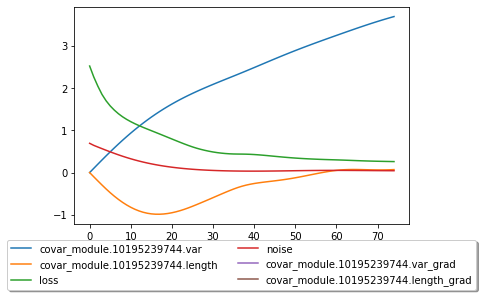

In [11]:
for param_key in param_dict:
    if param_key == 'task_noises':
        pass
    else:
        plt.plot(param_dict[param_key], label=param_key)
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)


In [12]:
print(likelihood.noise)
print(likelihood.task_noises)

tensor([0.0433], grad_fn=<AddBackward0>)
tensor([1.0000e-04, 1.0000e-04], grad_fn=<AddBackward0>)


In [13]:
A = matrix(QQ, 4, 4, (2,0,0.6065,0.6065,0,1,-0.6065,0.6065,0.6065,-0.6065,2,0,0.6065,0.6065,0,1))
L = A.cholesky()
L*L.transpose()

[  2.000000000000000?                    0  0.6065000000000000?  0.6065000000000000?]
[                   0                    1 -0.6065000000000000?  0.6065000000000000?]
[ 0.6065000000000000? -0.6065000000000000?   2.000000000000000?              0.?e-18]
[ 0.6065000000000000?  0.6065000000000000?              0.?e-18   1.000000000000000?]

In [14]:
for parameter in model.named_parameters():
    print(parameter)

('likelihood.raw_task_noises', Parameter containing:
tensor([-inf, -inf], requires_grad=True))
('likelihood.raw_noise', Parameter containing:
tensor([-3.1207], requires_grad=True))
('covar_module.10195239744.var', Parameter containing:
tensor(3.7231, requires_grad=True))
('covar_module.10195239744.length', Parameter containing:
tensor(0.0761, requires_grad=True))


In [15]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots

number_of_samples = int(120)
# Make predictions
with torch.no_grad():#, gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(float(-2), float(7), number_of_samples)
    #pdb.set_trace()
    outputs = model(test_x)
    predictions = likelihood(outputs)
    
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
#print(mean)
#print(lower)
#print(upper)
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

#dims = int(2)
#indices = [list(range(i, len(train_y), dims)) for i in range(dims)]


tensor([[41.3908,  0.0000, 41.2725,  ..., -0.1907,  0.0429, -0.1475],
        [ 0.0000, 35.5499,  2.8937,  ..., -0.5932,  0.1475, -0.4699],
        [41.2725,  2.8937, 41.3908,  ..., -0.2451,  0.0567, -0.1907],
        ...,
        [-0.1907, -0.5932, -0.2451,  ..., 35.5499,  2.8937, 35.2454],
        [ 0.0429,  0.1475,  0.0567,  ...,  2.8937, 41.3908,  0.0000],
        [-0.1475, -0.4699, -0.1907,  ..., 35.2454,  0.0000, 35.5499]])
torch.return_types.eig(
eigenvalues=tensor([[ 1.3808e+03,  0.0000e+00],
        [ 1.1048e+03,  0.0000e+00],
        [ 6.8434e+02,  0.0000e+00],
        [ 4.1595e+02,  0.0000e+00],
        [ 1.8724e+02,  0.0000e+00],
        [ 5.8346e+01,  0.0000e+00],
        [ 1.2957e+01,  0.0000e+00],
        [ 2.2616e+00,  0.0000e+00],
        [ 3.2716e-01,  0.0000e+00],
        [ 4.0505e-02,  0.0000e+00],
        [ 4.3763e-03,  0.0000e+00],
        [ 4.2779e-04,  0.0000e+00],
        [ 6.1832e-05,  0.0000e+00],
        [-1.6556e-05,  5.4729e-05],
        [-1.6556e-05, -5.4

Text(0.5, 1.0, 'Observed Values (Likelihood)')

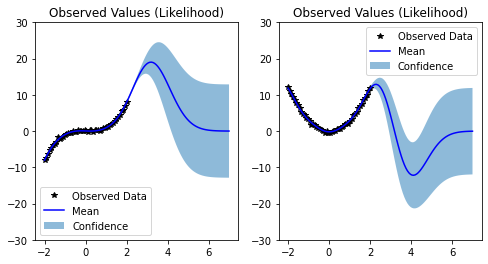

In [16]:
f, (y1_ax, y2_ax) = plt.subplots(int(1), int(2), figsize=(int(8), int(4)))

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-30, 30])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-30, 30])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')


In [17]:
a = matrix(1, 2, (1, 2))
b = matrix(2, 2, (1, 2, 3, 4))
a*b

[ 7 10]

# Test Diffable SE Kernel

In [18]:
X = torch.tensor([int(1), int(2), int(3)])
X

tensor([1, 2, 3])

In [19]:
X = torch.linspace(float(-2), float(2), int(1))

In [20]:
x1, x2, l, sigma = var('x1, x2, l, sigma')
lengthscale = 1
variance = 1
SE(x1, x2, l, sigma) = sigma^2*exp(-(x1-x2)^2/(2*l^2))
cov_matr = [[None for i in range(len(X))] for j in range(len(X))]
for i, (v1, v2) in enumerate(product(X, X)):
    cov_matr[int(i/len(X))][int(i%len(X))] = float(SE.diff(x2).diff(x1).diff(x1).diff(x2)(int(v1), int(v2), lengthscale, variance))
cov_matr

[[3.0]]

In [21]:
print(SE)
print(SE.diff(x1))
print(SE.diff(x1).diff(x2))
print(SE.diff(x1).diff(x2).diff(x1))
print(SE.diff(x1).diff(x2).diff(x1).diff(x2))
float(SE.diff(x2).diff(x1)(float(1.), float(1.), 1, 1))

(x1, x2, l, sigma) |--> sigma^2*e^(-1/2*(x1 - x2)^2/l^2)
(x1, x2, l, sigma) |--> -sigma^2*(x1 - x2)*e^(-1/2*(x1 - x2)^2/l^2)/l^2
(x1, x2, l, sigma) |--> sigma^2*e^(-1/2*(x1 - x2)^2/l^2)/l^2 - sigma^2*(x1 - x2)^2*e^(-1/2*(x1 - x2)^2/l^2)/l^4
(x1, x2, l, sigma) |--> -3*sigma^2*(x1 - x2)*e^(-1/2*(x1 - x2)^2/l^2)/l^4 + sigma^2*(x1 - x2)^3*e^(-1/2*(x1 - x2)^2/l^2)/l^6
(x1, x2, l, sigma) |--> 3*sigma^2*e^(-1/2*(x1 - x2)^2/l^2)/l^4 - 6*sigma^2*(x1 - x2)^2*e^(-1/2*(x1 - x2)^2/l^2)/l^6 + sigma^2*(x1 - x2)^4*e^(-1/2*(x1 - x2)^2/l^2)/l^8


1.0

In [22]:
a = Diff_SE_kernel(var=int(variance), length=int(lengthscale))
q, dx1, dx2 = var('q, dx1, dx2')
left_poly = dx2
right_poly = dx1 
diffed_kernel = a.diff(left_poly=left_poly, right_poly=right_poly, left_d_var=var('dx2'), right_d_var=var('dx1'))
left_poly = dx2
right_poly = 1
diffed_kernel2 = a.diff(left_poly=left_poly, right_poly=right_poly, left_d_var=var('dx2'), right_d_var=var('dx1'))
diffed_kernel(X).evaluate() + diffed_kernel2(X).evaluate()

tensor([[0.3679]], grad_fn=<AddBackward0>)

In [23]:
def calc_cell_diff(L, M, R, context=None):
    len_M = np.shape(M)[0]
    temp = None
    # https://stackoverflow.com/questions/6473679/transpose-list-
    # of-lists
    M_transpose = list(
       map(list, itertools.zip_longest(*M, fillvalue=None)))
    for r_elem, row_M in zip(R, M_transpose):
        for l_elem, m_elem in zip(L, row_M):
            if temp is None:
                #if M_transpose[int(j/len_M)][j % len_M] is not None:
                if m_elem is not None:
                    temp = l_elem * m_elem*r_elem
                    #temp = l_elem * M_transpose[int(j/len_M)][j % len_M]*r_elem
                else:
                    pass
            else:
                if m_elem is not None:
                #if M_transpose[int(j/len_M)][j % len_M] is not None:
                    temp += l_elem * m_elem*r_elem
                    #temp += l_elem * M_transpose[int(j/len_M)][j % len_M]*r_elem
                else:
                    pass
    return temp.simplify_full()


In [24]:
dimension = 3
length = dimension*dimension +1
L_list = [var(f'l_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
M_list = [var(f'm_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
R_list = [var(f'r_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
L = matrix(dimension, dimension, L_list)
M = matrix(dimension, dimension, M_list)
R = matrix(dimension, dimension, R_list)
print(L)
print(M)
print(R)
row = 0
col = 0
for row in range(dimension):
    for col in range(dimension):
        print((L*M*R)[row][col])
print("\n\n")
for i, (l, r) in enumerate(itertools.product(L.rows(), R.columns())):

    print(calc_cell_diff(l, M, r))
    print("\n")

[l_11 l_12 l_13]
[l_21 l_22 l_23]
[l_31 l_32 l_33]
[m_11 m_12 m_13]
[m_21 m_22 m_23]
[m_31 m_32 m_33]
[r_11 r_12 r_13]
[r_21 r_22 r_23]
[r_31 r_32 r_33]
(l_11*m_11 + l_12*m_21 + l_13*m_31)*r_11 + (l_11*m_12 + l_12*m_22 + l_13*m_32)*r_21 + (l_11*m_13 + l_12*m_23 + l_13*m_33)*r_31
(l_11*m_11 + l_12*m_21 + l_13*m_31)*r_12 + (l_11*m_12 + l_12*m_22 + l_13*m_32)*r_22 + (l_11*m_13 + l_12*m_23 + l_13*m_33)*r_32
(l_11*m_11 + l_12*m_21 + l_13*m_31)*r_13 + (l_11*m_12 + l_12*m_22 + l_13*m_32)*r_23 + (l_11*m_13 + l_12*m_23 + l_13*m_33)*r_33
(l_21*m_11 + l_22*m_21 + l_23*m_31)*r_11 + (l_21*m_12 + l_22*m_22 + l_23*m_32)*r_21 + (l_21*m_13 + l_22*m_23 + l_23*m_33)*r_31
(l_21*m_11 + l_22*m_21 + l_23*m_31)*r_12 + (l_21*m_12 + l_22*m_22 + l_23*m_32)*r_22 + (l_21*m_13 + l_22*m_23 + l_23*m_33)*r_32
(l_21*m_11 + l_22*m_21 + l_23*m_31)*r_13 + (l_21*m_12 + l_22*m_22 + l_23*m_32)*r_23 + (l_21*m_13 + l_22*m_23 + l_23*m_33)*r_33
(l_31*m_11 + l_32*m_21 + l_33*m_31)*r_11 + (l_31*m_12 + l_32*m_22 + l_33*m_32)*r_21 +

In [25]:
def calc_cell_diff_sage(L, M, R, context=None):
    temp = None
    # https://stackoverflow.com/questions/6473679/transpose-list-
    # of-lists
    M_transpose = list(
        map(list, itertools.zip_longest(*M, fillvalue=None)))
    # Every row in 'M' is combined with each elem of the row given in 'R'
    # Or: For each elemtn in row 'R' combine with 'row_M'
    for r_elem, row_M in zip(R, M_transpose):
        # Each element in L gets exactly one element in 'row_M' to multiply
        # Or: Combine each element in row_M with exactly one element in 'L'
        for l_elem, m_elem in zip(L, row_M):
            if temp is None:
                if m_elem is not None:
                    if not l_elem == 0 and not r_elem == 0:
                        temp = m_elem.diff(l_elem).diff(r_elem)
                    #elif l_elem == 0 and not r_elem == 0:
                    #    temp = m_elem.diff(r_elem)
                    #elif not l_elem == 0 and r_elem == 0:
                    #    temp = m_elem.diff(l_elem)
                else:
                    pass
            else:
                if m_elem is not None:
                    if not l_elem == 0 and not r_elem == 0:
                        temp += m_elem.diff(l_elem).diff(r_elem)
                    #elif l_elem == 0 and not r_elem == 0:
                    #    temp += m_elem.diff(r_elem)
                    #elif not l_elem == 0 and r_elem == 0:
                    #    temp += m_elem.diff(l_elem)
                    
                else:
                    pass
    return temp

def diff_sage(matrix, left_matrix=None, right_matrix=None):
    # iterate left matrix by rows and right matrix by columns and call the
    # respective diff command of the kernels with the row/cols as params
    kernel = MatrixKernel(None)
    output_matrix = [[0 for i in range(np.shape(matrix)[1])] for j in range(np.shape(matrix)[0])]
    for i, (l, r) in enumerate(itertools.product(left_matrix.rows(), right_matrix.columns())):
        res = calc_cell_diff_sage(l, matrix, r, context=kernel)
        output_matrix[int(i/np.shape(matrix)[0])][
                    int(i % np.shape(matrix)[0])]  = res
    kernel.set_matrix(output_matrix)
    return output_matrix


In [26]:
import pprint
L = matrix(2, 2, (x1, x1, 0, x1))
R = matrix(2, 2, (x2, 0, x2, x2))
x1, x2, l, sigma, l2, sigma2 = var('x1, x2, l, sigma, l2, sigma2')
lengthscale = torch.nn.functional.softplus(torch.tensor(float(0.0)))
variance = 1
lengthscale2 = torch.nn.functional.softplus(torch.tensor(float(0.0)))
variance2 = 1
SEKernelMatrix = [[sigma^2*exp(-(x1-x2)^2/(2*l^2)), sigma2^2*exp(-(x1-x2)^2/(2*l2^2))], [sigma2^2*exp(-(x1-x2)^2/(2*l2^2)), sigma^2*exp(-(x1-x2)^2/(2*l^2))]]
#diffed_SE_sage_matrix_kernel = diff_sage(SEKernelMatrix, left_matrix=L, right_matrix=R)
#pprint.pprint(diffed_SE_sage_matrix_kernel)
cov_matr = [[None for i in range(len(X)*len(SEKernelMatrix))] for j in range(len(X)*len(SEKernelMatrix))]
for i, (v1, v2) in enumerate(product(X, X)):
    for row in range(len(SEKernelMatrix)):
        for col in range(len(SEKernelMatrix)):
            # Blockwise
            #cov_matr[int(i/len(X))+row*len(X)][int(i%len(X))+col*len(X)] = SEKernelMatrix[row][col].substitute(x1=int(v1), x2=int(v2), l=float(lengthscale), sigma=variance, l2=float(lengthscale2), sigma2=variance2)
            # Interleaved
            text=f"x-pos: {int(((i*len(SEKernelMatrix))+row)/(len(X)*len(SEKernelMatrix)))*2+row}" +\
            f" y-pos: {int((i*len(SEKernelMatrix))+col)%(len(X)*len(SEKernelMatrix))}" + \
            f" x1, x2: {v1}, {v2}\n" +\
            f"(x1-x2)^2: {(v1-v2)**2}"+\
            f" exp((x1-x2)^2): {np.exp((v1-v2)**2)}\n"+\
            f"val: {float(SEKernelMatrix[row][col].substitute(x1=float(v1), x2=float(v2), l=float(lengthscale), sigma=variance, l2=float(lengthscale2), sigma2=variance2))}"
            print(text)
            print("---")
            cov_matr[int(((i*len(SEKernelMatrix))+row)/(len(X)*len(SEKernelMatrix)))*2+row][int((i*len(SEKernelMatrix))+col)%(len(X)*len(SEKernelMatrix))] = float(SEKernelMatrix[row][col].substitute(x1=float(v1), x2=float(v2), l=float(lengthscale), sigma=variance, l2=float(lengthscale2), sigma2=variance2))
cov_matr


x-pos: 0 y-pos: 0 x1, x2: -2.0, -2.0
(x1-x2)^2: 0.0 exp((x1-x2)^2): 1.0
val: 1.0
---
x-pos: 0 y-pos: 1 x1, x2: -2.0, -2.0
(x1-x2)^2: 0.0 exp((x1-x2)^2): 1.0
val: 1.0
---
x-pos: 1 y-pos: 0 x1, x2: -2.0, -2.0
(x1-x2)^2: 0.0 exp((x1-x2)^2): 1.0
val: 1.0
---
x-pos: 1 y-pos: 1 x1, x2: -2.0, -2.0
(x1-x2)^2: 0.0 exp((x1-x2)^2): 1.0
val: 1.0
---


[[1.0, 1.0], [1.0, 1.0]]

In [27]:
print(X)
print(torch.Tensor(cov_matr).eig())

tensor([-2.])
torch.return_types.eig(
eigenvalues=tensor([[2., 0.],
        [0., 0.]]),
eigenvectors=tensor([]))


In [28]:
exp(-(-2-0.66)^2/(2))

0.0290772266655467

In [29]:

kernel = Diff_SE_kernel()
kernel2 = Diff_SE_kernel()
q, dx1, dx2 = var('q, dx1, dx2')
L = matrix(2, 2, (dx1, dx1, 0, dx1))
R = matrix(2, 2, (dx2, 0, dx2, dx2))

p = DiffMatrixKernel([[kernel, None], [None, kernel2]])
covar_module = p.diff(left_matrix=L, right_matrix=R)

covar_x = covar_module(X)
covar_x.evaluate()

List of all kernels: [Diff_SE_kernel(), Diff_SE_kernel()]
[[AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_SE_kernel()
    (1): diffed_SE_kernel()
  )
), AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_SE_kernel()
    (1): diffed_SE_kernel()
  )
)], [AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_SE_kernel()
    (1): diffed_SE_kernel()
  )
), AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_SE_kernel()
    (1): diffed_SE_kernel()
  )
)]]
tensor([[0.7358, 0.3679],
        [0.3679, 0.3679]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[0.9631, 0.0000],
        [0.1405, 0.0000]], grad_fn=<EigBackward>),
eigenvectors=tensor([], grad_fn=<EigBackward>))


tensor([[0.7358, 0.3679],
        [0.3679, 0.3679]], grad_fn=<CatBackward>)

In [30]:
matr = [[2, 0, -6*e^(-2), 1, e^(-1/2), -e^(-2)],
 [0, 2, 0, -e^(-1/2), 1, e^(-1/2)],
 [-6*e^(-2), 0, 2, -5*e^(-2), -e^(-1/2), 1],
 [1, e^(-1/2), -e^(-2), 1, 0, -3*e^(-2)],
 [-e^(-1/2), 1, e^(-1/2), 0, 1, 0],
 [-5*e^(-2), -e^(-1/2), 1, -3*e^(-2), 0, 1]]

matr = [[2, 0, -6*e^(-2), 1, 0, -3*e^(-2)],
 [0, 2, 0, 0, 1, 0],
 [-6*e^(-2), 0, 2, -3*e^(-2), 0, 1],
 [1, 0, -3*e^(-2), 1, 0, -3*e^(-2)],
 [0, 1, 0, 0, 1, 0],
 [-3*e^(-2), 0, 1, -3*e^(-2), 0, 1]]

matr = torch.Tensor(matr)
import pprint
pprint.pprint(matr)
print(matr[0::3, 0::3])
H_x = 3
torch.vstack([torch.hstack([matr[k::H_x, l::H_x] for l in range(H_x)]) for k in range(H_x)])

tensor([[ 2.0000,  0.0000, -0.8120,  1.0000,  0.0000, -0.4060],
        [ 0.0000,  2.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [-0.8120,  0.0000,  2.0000, -0.4060,  0.0000,  1.0000],
        [ 1.0000,  0.0000, -0.4060,  1.0000,  0.0000, -0.4060],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [-0.4060,  0.0000,  1.0000, -0.4060,  0.0000,  1.0000]])
tensor([[2., 1.],
        [1., 1.]])


tensor([[ 2.0000,  1.0000,  0.0000,  0.0000, -0.8120, -0.4060],
        [ 1.0000,  1.0000,  0.0000,  0.0000, -0.4060, -0.4060],
        [ 0.0000,  0.0000,  2.0000,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000],
        [-0.8120, -0.4060,  0.0000,  0.0000,  2.0000,  1.0000],
        [-0.4060, -0.4060,  0.0000,  0.0000,  1.0000,  1.0000]])

In [31]:
class testobject():
    def __init__(self, val):
        self.val = val
    
    def setVal(self, val):
        self.val = val
        
    def printVal(self):
        return self.val
    
    def __call__(self):
        return self.val

In [32]:
t1 = testobject(42)
t2 = testobject(21)
t3 = testobject(17)
l = [[t1, t2], [t2, t3]]
print(l)
t2.setVal(170)
print(l[0][1].printVal())
print(l[1][0].printVal())

[[<__main__.testobject object at 0x25fb1f460>, <__main__.testobject object at 0x25fa65400>], [<__main__.testobject object at 0x25fa65400>, <__main__.testobject object at 0x2612088b0>]]
170
170


In [33]:
q, dx1, dx2 = var('q, dx1, dx2')
left_poly = dx1
right_poly = dx2
L = matrix(2, 2, (dx1, 0, 0, dx1))
R = matrix(2, 2, (dx2, 0, 0, dx2))

In [34]:
p.diff(left_matrix=L, right_matrix=R).forward(X, X)

[[AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_SE_kernel()
    (1): diffed_SE_kernel()
  )
), AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_SE_kernel()
    (1): diffed_SE_kernel()
  )
)], [AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_SE_kernel()
    (1): diffed_SE_kernel()
  )
), AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_SE_kernel()
    (1): diffed_SE_kernel()
  )
)]]
tensor([[0.3679, 0.0000],
        [0.0000, 0.3679]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[0.3679, 0.0000],
        [0.3679, 0.0000]], grad_fn=<EigBackward>),
eigenvectors=tensor([], grad_fn=<EigBackward>))


tensor([[0.3679, 0.0000],
        [0.0000, 0.3679]], grad_fn=<CatBackward>)

In [35]:
w, q, dx1, dx2 = var('w, q, dx1, dx2')
a = dx1^2
#a.degree(dx1)
a.operands()

[dx1, 2]

In [36]:
prod([1,2,3])

6

In [37]:
a = torch.Tensor([[int(1), int(2), int(3)], [int(4), int(5), int(6)], [int(7), int(8), int(9)]])
for i, row in enumerate(a):
    for j, elem in enumerate(row[i:]):
        print(f"row: {i}, col: {i+j}")
        print(elem)

row: 0, col: 0
tensor(1.)
row: 0, col: 1
tensor(2.)
row: 0, col: 2
tensor(3.)
row: 1, col: 1
tensor(5.)
row: 1, col: 2
tensor(6.)
row: 2, col: 2
tensor(9.)


In [38]:
a, b, c, d = var('a, b, c, d')
A = matrix(2,2, (a, b, c, d))
B = matrix(2, 2, (dx1, dx1, 0, dx1))
C = matrix(2, 2, (dx2, 0, dx2, dx2))
print(A)
print(B)
B*A

[a b]
[c d]
[dx1 dx1]
[  0 dx1]


[a*dx1 + c*dx1 b*dx1 + d*dx1]
[        c*dx1         d*dx1]

In [39]:
x = ['a', 'b', 'c']
y = x                 # x and y reference the same object
z = ['a', 'b', 'c']   # x and z reference different objects
#z


print(x is z)
z = x
print(x is z)


False
True
